# Heliocentricity Analysis - FIXED

## ⚠️ CRITICAL BUG FIX APPLIED

**Previous Issue**: The heliocentricity calculation was hardcoded to use `star_idx = 4`, which meant it was only computing scores for whatever player happened to be at index 4 in each play (often the QB or a random position player), NOT the actual targeted receiver.

**Fix Applied**: Modified `ghost.ipynb` to:
1. Include `player_to_predict` flag from input CSVs in data preprocessing
2. Store the target player ID in metadata during processing  
3. Calculate correct `star_idx` by finding which index corresponds to the targeted receiver
4. Only compute heliocentricity for plays where we have a valid target player

**Impact**: 
- Previous play counts per player were artificially low (only ~10-50 plays each)
- Scores were meaningless (measuring random players, not targets)
- **Need to rerun the entire pipeline** to regenerate valid heliocentricity scores

## Next Steps
1. Delete cached processed data: `dataset/processed/processed_data.pt`
2. Rerun `ghost.ipynb` to regenerate data with correct player identification
3. Rerun this analysis notebook with the corrected scores

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load and Explore Data

In [2]:
# Load heliocentricity scores
helio_df = pd.read_csv('dataset/helio/heliocentricity_scores.csv')

# Load player names from input files
print("Loading player names from input files...")
train_path = Path('dataset/train')
input_files = sorted(train_path.glob('input*.csv'))

# Read just the unique player mappings from all weeks
player_dfs = []
for file in input_files:
    df = pd.read_csv(file, usecols=['nfl_id', 'player_name'])
    player_dfs.append(df)

players_df = pd.concat(player_dfs, ignore_index=True).drop_duplicates(subset=['nfl_id'])
players_df.columns = ['star_player_id', 'player_name']

print(f"Loaded {len(players_df)} unique player names")

# Merge player names with heliocentricity scores
helio_df = helio_df.merge(players_df, on='star_player_id', how='left')

print(f"\nLoaded {len(helio_df):,} plays with heliocentricity scores")
print(f"Unique players: {helio_df['star_player_id'].nunique()}")
print(f"Players with names: {helio_df['player_name'].notna().sum()} ({helio_df['player_name'].notna().sum() / len(helio_df) * 100:.1f}%)")
print(f"\nHeliocentricity Score Statistics:")
print(helio_df['H_score'].describe())

# Show sample data
print("\nSample data:")
helio_df[['game_id', 'play_id', 'star_player_id', 'player_name', 'H_score']].head(10)

Loading player names from input files...
Loaded 1384 unique player names

Loaded 2,822 plays with heliocentricity scores
Unique players: 428
Players with names: 2822 (100.0%)

Heliocentricity Score Statistics:
count    2822.000000
mean        5.166631
std         4.626184
min        -7.911664
25%         2.119028
50%         4.256190
75%         7.309910
max        29.571606
Name: H_score, dtype: float64

Sample data:
Loaded 1384 unique player names

Loaded 2,822 plays with heliocentricity scores
Unique players: 428
Players with names: 2822 (100.0%)

Heliocentricity Score Statistics:
count    2822.000000
mean        5.166631
std         4.626184
min        -7.911664
25%         2.119028
50%         4.256190
75%         7.309910
max        29.571606
Name: H_score, dtype: float64

Sample data:


,game_id,play_id,star_player_id,player_name,H_score
0,2023091011,2834,44862,Justin Evans,-2.107699
1,2023101507,3581,46248,Parry Nickerson,2.618695
2,2023121708,649,46077,Roquan Smith,2.114915
3,2023110507,3045,52458,Jaylon Johnson,5.813387
4,2023100106,3723,52844,Christian Rozeboom,3.719914
5,2023100500,1631,47871,Cody Barton,3.722668
6,2023091710,3659,46088,Leighton Vander Esch,3.257077
7,2023121006,2931,47881,Quincy Williams,-1.133264
8,2023092501,4318,47855,Germaine Pratt,5.275827
9,2023121705,3520,46140,Royce Freeman,4.692144


In [3]:
# Check for any missing values or data quality issues
print("Missing values:")
print(helio_df.isnull().sum())

print("\nData types:")
print(helio_df.dtypes)

# Distribution of H_scores
print(f"\nH_score range: [{helio_df['H_score'].min():.2f}, {helio_df['H_score'].max():.2f}]")
print(f"Negative scores (defense closer than expected): {(helio_df['H_score'] < 0).sum()} ({(helio_df['H_score'] < 0).sum() / len(helio_df) * 100:.1f}%)")
print(f"Positive scores (defense farther than expected): {(helio_df['H_score'] > 0).sum()} ({(helio_df['H_score'] > 0).sum() / len(helio_df) * 100:.1f}%)")

Missing values:
game_id           0
play_id           0
H_score           0
star_player_id    0
player_name       0
dtype: int64

Data types:
game_id             int64
play_id             int64
H_score           float64
star_player_id      int64
player_name        object
dtype: object

H_score range: [-7.91, 29.57]
Negative scores (defense closer than expected): 227 (8.0%)
Positive scores (defense farther than expected): 2595 (92.0%)


## 2. Player-Level Aggregation

In [4]:
# Aggregate heliocentricity by player
player_stats = helio_df.groupby('star_player_id').agg({
    'H_score': ['mean', 'median', 'std', 'min', 'max', 'count'],
    'game_id': 'nunique',
    'play_id': 'count',
    'player_name': 'first'  # Get player name
}).round(3)

# Flatten column names
player_stats.columns = ['_'.join(col).strip() for col in player_stats.columns.values]
player_stats.rename(columns={
    'H_score_mean': 'avg_H_score',
    'H_score_median': 'median_H_score',
    'H_score_std': 'std_H_score',
    'H_score_min': 'min_H_score',
    'H_score_max': 'max_H_score',
    'H_score_count': 'total_plays',
    'game_id_nunique': 'games_played',
    'player_name_first': 'player_name'
}, inplace=True)

# Calculate coefficient of variation (consistency metric)
player_stats['cv'] = (player_stats['std_H_score'] / player_stats['avg_H_score'].abs()).replace([np.inf, -np.inf], np.nan)

# Reset index
player_stats = player_stats.reset_index()

print(f"Player-level statistics calculated for {len(player_stats)} players")
print(f"\nPlayers with at least 10 plays: {(player_stats['total_plays'] >= 10).sum()}")
player_stats.head(10)

Player-level statistics calculated for 428 players

Players with at least 10 plays: 103


,star_player_id,avg_H_score,median_H_score,std_H_score,min_H_score,max_H_score,total_plays,games_played,play_id_count,player_name,cv
0,42397,1.816,2.615,1.660,-0.093,2.925,3,1,3,Ameer Abdullah,0.914097
1,42485,4.111,4.239,2.816,0.956,8.568,6,1,6,Adrian Amos,0.684991
2,42794,6.602,6.602,NaN,6.602,6.602,1,1,1,DeAndre Carter,NaN
3,42901,3.228,3.228,NaN,3.228,3.228,1,1,1,Dean Marlowe,NaN
4,42929,8.131,8.131,NaN,8.131,8.131,1,1,1,Alex Singleton,NaN
5,43314,4.848,4.954,1.427,3.152,6.795,5,3,5,Artie Burns,0.294348
6,43324,4.504,4.504,4.174,1.553,7.455,2,1,2,Hunter Henry,0.926732
7,43325,2.080,1.690,4.287,-3.280,8.976,6,2,6,Myles Jack,2.061058
8,43329,12.205,12.205,12.111,3.641,20.769,2,1,2,Sterling Shepard,0.992298
9,43334,1.960,2.850,2.792,-1.169,4.198,3,2,3,Derrick Henry,1.424490


## 3. Top Players by Heliocentricity

In [5]:
# Filter for players with meaningful sample size (at least 10 plays)
qualified_players = player_stats[player_stats['total_plays'] >= 10].copy()

print(f"Analyzing {len(qualified_players)} players with 10+ plays\n")

# Top 15 players by average heliocentricity (most defensive attention)
print("=" * 80)
print("TOP 15 PLAYERS - HIGHEST HELIOCENTRICITY (Defense Gave Most Space)")
print("=" * 80)
top_players = qualified_players.nlargest(15, 'avg_H_score')[[
    'player_name', 'star_player_id', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games_played'
]]
print(top_players.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 15 PLAYERS - LOWEST HELIOCENTRICITY (Defense Played Tight Coverage)")
print("=" * 80)
bottom_players = qualified_players.nsmallest(15, 'avg_H_score')[[
    'player_name', 'star_player_id', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games_played'
]]
print(bottom_players.to_string(index=False))

Analyzing 103 players with 10+ plays

TOP 15 PLAYERS - HIGHEST HELIOCENTRICITY (Defense Gave Most Space)
        player_name  star_player_id  avg_H_score  median_H_score  std_H_score  total_plays  games_played
     L'Jarius Sneed           52546       11.902          12.900        5.471           10             6
          D.J. Reed           46211       10.902          10.842        4.822           27            11
       Isaac Yiadom           46168       10.613           8.740        6.144           11             7
     Jaylon Johnson           52458       10.509           8.180        5.742           13             8
         A.J. Brown           47834       10.208          11.597        5.914           22            10
Sean Murphy-Bunting           47822        9.907          10.736        6.912           14             8
   Shaquill Griffin           44902        9.717           7.384        5.727           13             6
         DK Metcalf           47847        9.657       

In [6]:
# Most consistent players (low coefficient of variation)
print("=" * 80)
print("MOST CONSISTENT PLAYERS (Low Variability in Heliocentricity)")
print("=" * 80)
consistent_players = qualified_players.nsmallest(15, 'cv')[[
    'player_name', 'star_player_id', 'avg_H_score', 'std_H_score', 'cv', 'total_plays'
]]
print(consistent_players.to_string(index=False))

print("\n" + "=" * 80)
print("MOST VARIABLE PLAYERS (High Variability in Heliocentricity)")
print("=" * 80)
variable_players = qualified_players.nlargest(15, 'cv')[[
    'player_name', 'star_player_id', 'avg_H_score', 'std_H_score', 'cv', 'total_plays'
]]
print(variable_players.to_string(index=False))

MOST CONSISTENT PLAYERS (Low Variability in Heliocentricity)
     player_name  star_player_id  avg_H_score  std_H_score       cv  total_plays
  Gerald Everett           44856        4.720        1.357 0.287500           13
     Jeff Okudah           52411        9.048        2.961 0.327255           12
Deebo Samuel Sr.           47819        8.148        2.863 0.351375           10
   Jourdan Lewis           44904        5.758        2.173 0.377388           26
    Mark Andrews           46155        2.888        1.237 0.428324           11
    Amani Hooker           47899        5.743        2.514 0.437750           16
       D.J. Reed           46211       10.902        4.822 0.442304           27
  T.J. Hockenson           47791        3.764        1.690 0.448990           14
   Taron Johnson           46190        5.129        2.339 0.456034           23
  L'Jarius Sneed           52546       11.902        5.471 0.459671           10
   Michael Davis           45571        7.723   

## 4. Extreme Plays Analysis

In [7]:
# Top individual plays by heliocentricity
print("=" * 80)
print("TOP 20 PLAYS - HIGHEST HELIOCENTRICITY")
print("=" * 80)
top_plays = helio_df.nlargest(20, 'H_score')[['player_name', 'game_id', 'play_id', 'star_player_id', 'H_score']]
print(top_plays.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 20 PLAYS - LOWEST HELIOCENTRICITY (Tightest Coverage)")
print("=" * 80)
bottom_plays = helio_df.nsmallest(20, 'H_score')[['player_name', 'game_id', 'play_id', 'star_player_id', 'H_score']]
print(bottom_plays.to_string(index=False))

TOP 20 PLAYS - HIGHEST HELIOCENTRICITY
        player_name    game_id  play_id  star_player_id   H_score
     Michael Gallup 2023122410      295           46150 29.571606
        CeeDee Lamb 2023112301      818           52425 28.483501
   Courtland Sutton 2023111300      710           46109 27.243906
      Fabian Moreau 2023123112     4243           44893 27.152332
     Tyson Campbell 2024010702     3294           53462 26.303003
       James Conner 2023111904      799           44917 24.996729
         David Long 2023102201      424           47862 24.254944
       Isaac Yiadom 2023120301     2169           46168 24.212880
        Matt Breida 2023100804     3205           45186 23.324017
JuJu Smith-Schuster 2023091712     3306           44874 23.320347
      DeVonta Smith 2023122501     3510           53439 22.323410
   Chris Godwin Jr. 2023100107     1936           44896 22.234670
    Michael Pittman 2023123105     2672           52442 21.508465
Sean Murphy-Bunting 2024010702     18

## 5. Visualizations

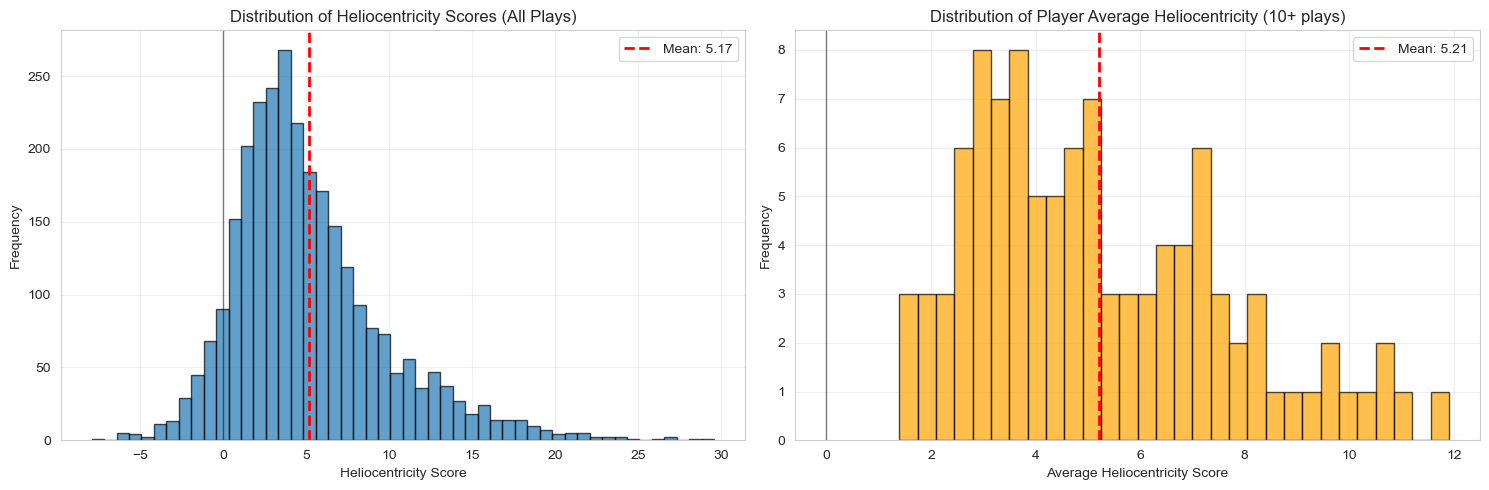

In [8]:
# Distribution of heliocentricity scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(helio_df['H_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(helio_df['H_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {helio_df['H_score'].mean():.2f}")
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Heliocentricity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Heliocentricity Scores (All Plays)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Player average distribution
axes[1].hist(qualified_players['avg_H_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(qualified_players['avg_H_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {qualified_players['avg_H_score'].mean():.2f}")
axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Average Heliocentricity Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Player Average Heliocentricity (10+ plays)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

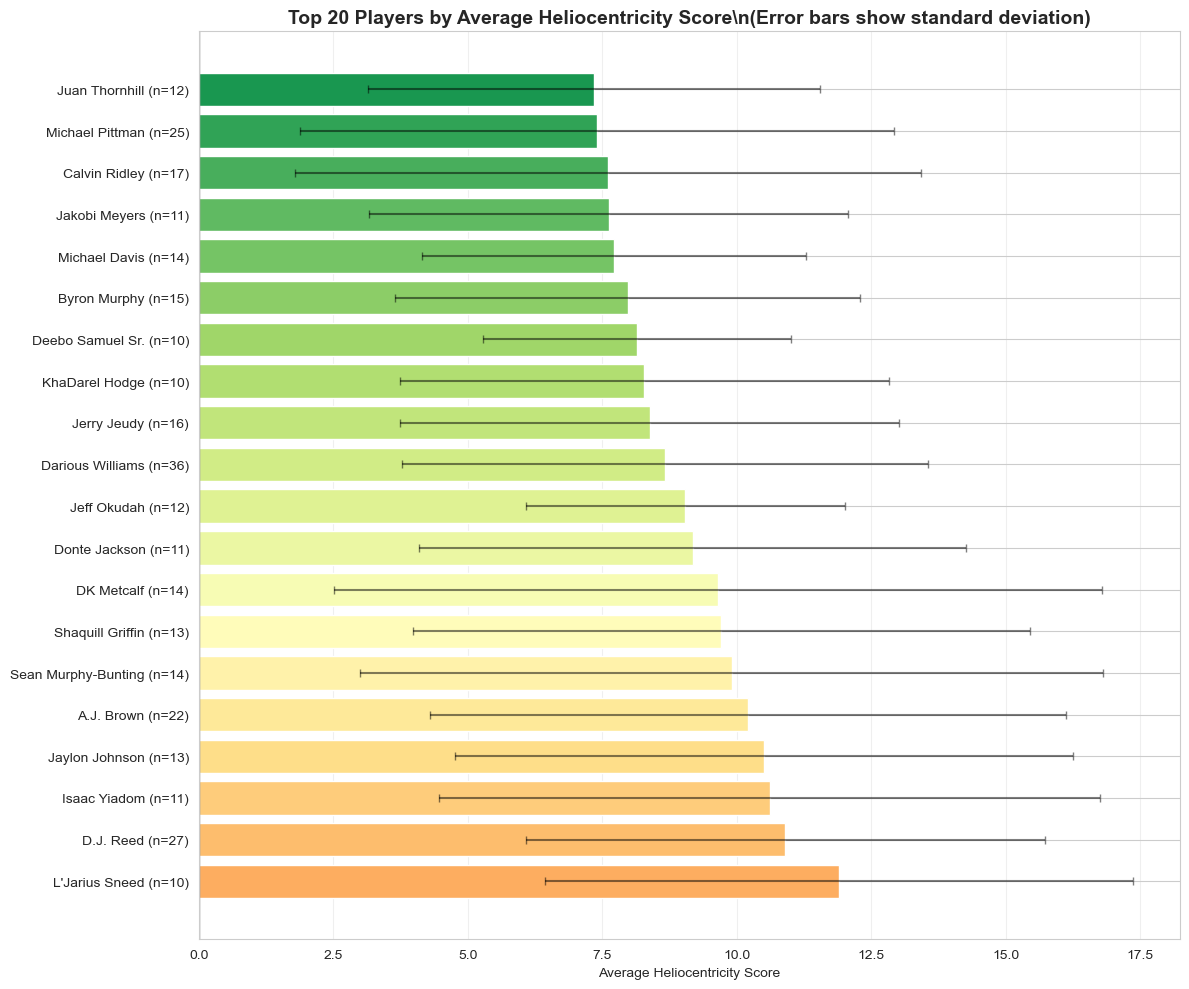

In [9]:
# Top 20 players visualization
top_20 = qualified_players.nlargest(20, 'avg_H_score')

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_20)), top_20['avg_H_score'], 
               color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_20))))

# Add error bars for standard deviation
ax.errorbar(top_20['avg_H_score'], range(len(top_20)), 
            xerr=top_20['std_H_score'], fmt='none', ecolor='black', alpha=0.5, capsize=3)

ax.set_yticks(range(len(top_20)))
ax.set_yticklabels([f"{name} (n={n})" for name, n in zip(top_20['player_name'], top_20['total_plays'])])
ax.set_xlabel('Average Heliocentricity Score')
ax.set_title('Top 20 Players by Average Heliocentricity Score\\n(Error bars show standard deviation)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

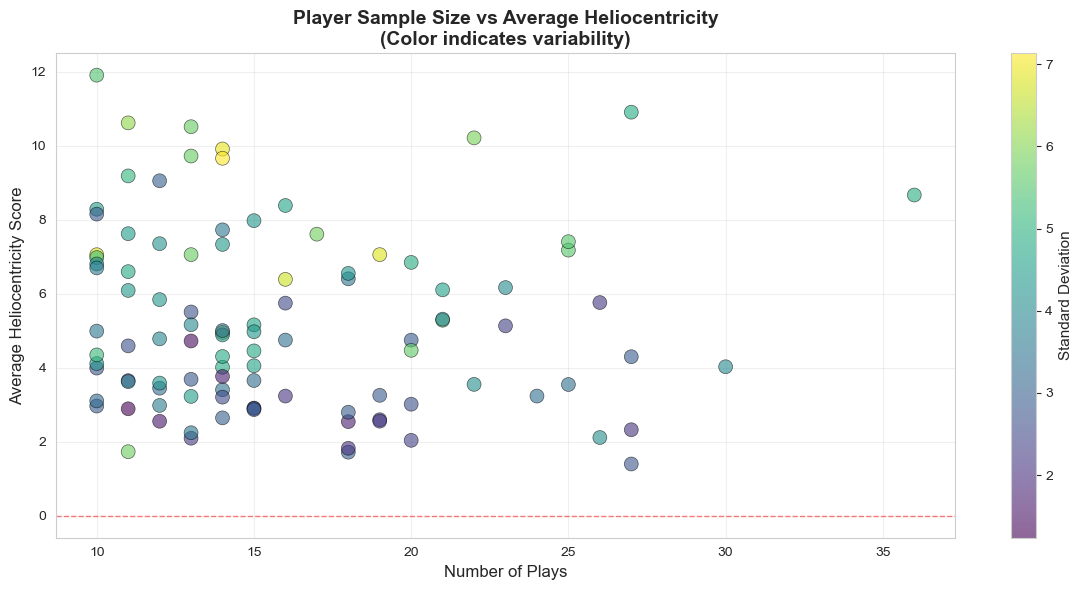

In [10]:
# Scatter: Sample size vs Average Heliocentricity
fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(qualified_players['total_plays'], 
                     qualified_players['avg_H_score'],
                     c=qualified_players['std_H_score'],
                     s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)

ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Plays', fontsize=12)
ax.set_ylabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Player Sample Size vs Average Heliocentricity\n(Color indicates variability)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Standard Deviation', fontsize=11)

plt.tight_layout()
plt.show()

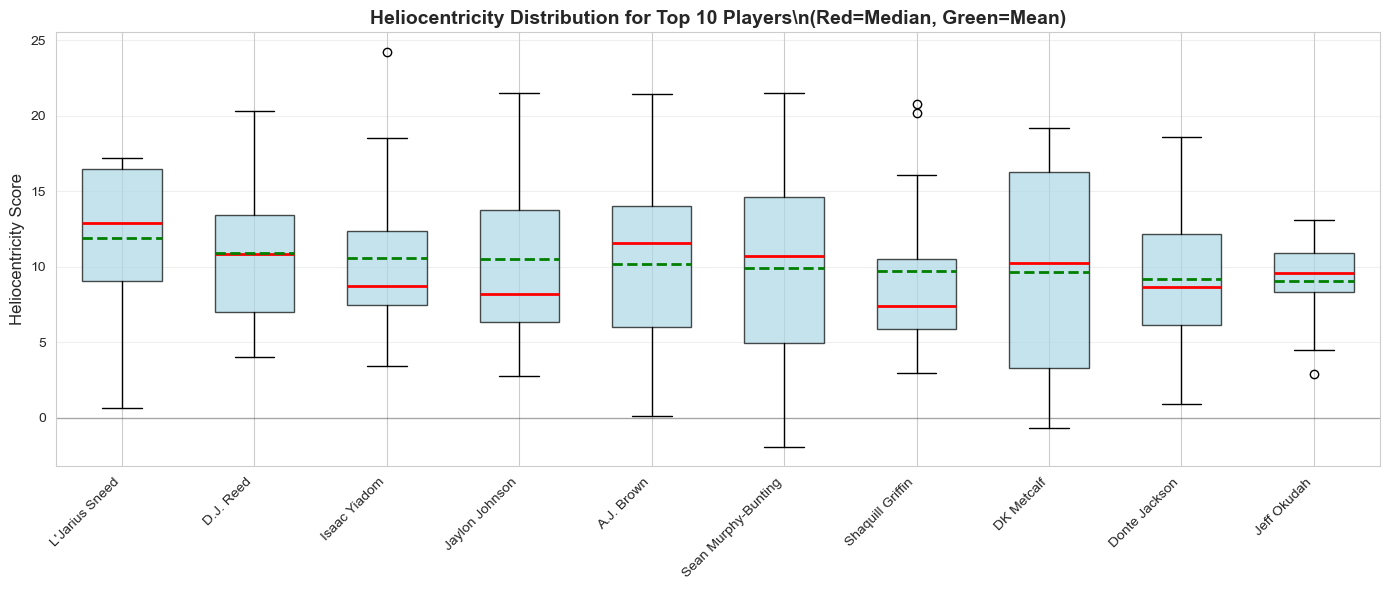

In [11]:
# Box plot: Distribution comparison for top 10 players
top_10 = qualified_players.nlargest(10, 'avg_H_score')
top_10_ids = top_10['star_player_id'].values
top_10_names = top_10['player_name'].values
top_10_data = helio_df[helio_df['star_player_id'].isin(top_10_ids)]

fig, ax = plt.subplots(figsize=(14, 6))

# Create box plot
positions = range(len(top_10_ids))
box_data = [top_10_data[top_10_data['star_player_id'] == pid]['H_score'].values for pid in top_10_ids]

bp = ax.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                showmeans=True, meanline=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(color='green', linewidth=2, linestyle='--'))

ax.set_xticks(positions)
ax.set_xticklabels(top_10_names, rotation=45, ha='right')
ax.set_ylabel('Heliocentricity Score', fontsize=12)
ax.set_title('Heliocentricity Distribution for Top 10 Players\\n(Red=Median, Green=Mean)', fontsize=14, fontweight='bold')
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Summary Statistics and Insights

In [12]:
print("=" * 80)
print("OVERALL SUMMARY")
print("=" * 80)
print(f"Total plays analyzed: {len(helio_df):,}")
print(f"Unique players: {helio_df['star_player_id'].nunique()}")
print(f"Players with 10+ plays: {len(qualified_players)}")
print(f"\nOverall Heliocentricity Statistics:")
print(f"  Mean: {helio_df['H_score'].mean():.3f}")
print(f"  Median: {helio_df['H_score'].median():.3f}")
print(f"  Std Dev: {helio_df['H_score'].std():.3f}")
print(f"  Min: {helio_df['H_score'].min():.3f}")
print(f"  Max: {helio_df['H_score'].max():.3f}")
print(f"\nInterpretation:")
print(f"  - Positive H-score: Defense gave MORE space than expected (commanded attention)")
print(f"  - Negative H-score: Defense played TIGHTER coverage than expected")
print(f"  - Zero: Defense coverage matched expectations")

# Percentile breakdown
print(f"\nPercentile Breakdown:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(helio_df['H_score'], p):.3f}")

OVERALL SUMMARY
Total plays analyzed: 2,822
Unique players: 428
Players with 10+ plays: 103

Overall Heliocentricity Statistics:
  Mean: 5.167
  Median: 4.256
  Std Dev: 4.626
  Min: -7.912
  Max: 29.572

Interpretation:
  - Positive H-score: Defense gave MORE space than expected (commanded attention)
  - Negative H-score: Defense played TIGHTER coverage than expected
  - Zero: Defense coverage matched expectations

Percentile Breakdown:
  10th percentile: 0.408
  25th percentile: 2.119
  50th percentile: 4.256
  75th percentile: 7.310
  90th percentile: 11.458
  95th percentile: 14.162
  99th percentile: 19.418


In [13]:
# Save processed player statistics
output_path = 'dataset/helio/player_heliocentricity_stats.csv'
qualified_players.to_csv(output_path, index=False)
print(f"✓ Saved player statistics to {output_path}")

# Save top/bottom players
top_players_output = 'dataset/helio/top_players_heliocentricity.csv'
qualified_players.nlargest(50, 'avg_H_score').to_csv(top_players_output, index=False)
print(f"✓ Saved top 50 players to {top_players_output}")

✓ Saved player statistics to dataset/helio/player_heliocentricity_stats.csv
✓ Saved top 50 players to dataset/helio/top_players_heliocentricity.csv


## 7. Wide Receiver Analysis

Focus on pass catchers (WR, TE) to identify elite players who commanded the most defensive attention.

In [14]:
# Load player positions from input files
print("Loading player positions...")

# Read positions from all weeks
position_dfs = []
for file in input_files:
    df = pd.read_csv(file, usecols=['nfl_id', 'player_position'])
    position_dfs.append(df)

positions_df = pd.concat(position_dfs, ignore_index=True).drop_duplicates(subset=['nfl_id'])
positions_df.columns = ['star_player_id', 'player_position']

# Merge positions with player stats
player_stats_with_pos = player_stats.merge(positions_df, on='star_player_id', how='left')

print(f"Loaded positions for {positions_df['star_player_id'].nunique()} players")
print(f"\nPosition distribution in dataset:")
print(player_stats_with_pos['player_position'].value_counts())

# Filter for pass catchers (WR and TE)
wr_stats = player_stats_with_pos[player_stats_with_pos['player_position'] == 'WR'].copy()
te_stats = player_stats_with_pos[player_stats_with_pos['player_position'] == 'TE'].copy()
pass_catcher_stats = player_stats_with_pos[player_stats_with_pos['player_position'].isin(['WR', 'TE'])].copy()

print(f"\nWide Receivers: {len(wr_stats)} players")
print(f"Tight Ends: {len(te_stats)} players")
print(f"Total Pass Catchers: {len(pass_catcher_stats)} players")

Loading player positions...
Loaded positions for 1384 players

Position distribution in dataset:
player_position
WR     82
CB     63
TE     46
FS     45
RB     40
SS     33
ILB    32
QB     30
OLB    30
MLB    17
FB      6
DE      3
S       1
Name: count, dtype: int64

Wide Receivers: 82 players
Tight Ends: 46 players
Total Pass Catchers: 128 players


### 7.1 Position Distribution Analysis

**Important Note:** Heliocentricity is designed to measure how much defensive attention an **offensive player** draws. Defensive players in the dataset indicate a conceptual issue - the metric doesn't make sense for defenders since they ARE the defense, not the target of defensive coverage.

In [15]:
# Analyze offensive vs defensive players in the dataset
print("=" * 80)
print("POSITION ANALYSIS: OFFENSIVE vs DEFENSIVE PLAYERS")
print("=" * 80)

# Define offensive and defensive positions
offensive_positions = ['WR', 'TE', 'RB', 'QB', 'FB']
defensive_positions = ['CB', 'FS', 'SS', 'S', 'ILB', 'OLB', 'MLB', 'DT', 'DE', 'LB']

player_stats_with_pos['side'] = player_stats_with_pos['player_position'].apply(
    lambda x: 'Offense' if x in offensive_positions else ('Defense' if x in defensive_positions else 'Unknown')
)

print("\nPlayer distribution by side:")
print(player_stats_with_pos['side'].value_counts())

offense_players = player_stats_with_pos[player_stats_with_pos['side'] == 'Offense']
defense_players = player_stats_with_pos[player_stats_with_pos['side'] == 'Defense']

print(f"\nOffensive players: {len(offense_players)} ({len(offense_players)/len(player_stats_with_pos)*100:.1f}%)")
print(f"Defensive players: {len(defense_players)} ({len(defense_players)/len(player_stats_with_pos)*100:.1f}%)")

print("\n" + "=" * 80)
print("WHY DEFENSIVE PLAYERS DON'T MAKE SENSE FOR HELIOCENTRICITY:")
print("=" * 80)
print("• Heliocentricity measures: 'How much defensive attention does this player draw?'")
print("• For offensive receivers: High H = Defense gave them MORE space than expected")
print("• For defensive players: Measuring distance from defender to OTHER defenders")
print("  → This doesn't measure 'attention' - it's just defender spacing")
print("  → A CB with high H means other defenders stayed far from the CB (not meaningful)")
print("\n✓ RECOMMENDATION: Filter to offensive pass catchers only (WR, TE, RB)")

# Show top defensive players (to illustrate the problem)
print("\n" + "=" * 80)
print("TOP 10 DEFENSIVE PLAYERS (This shouldn't be meaningful)")
print("=" * 80)
top_def = defense_players.nlargest(10, 'avg_H_score')[['player_name', 'player_position', 'avg_H_score', 'total_plays']]
print(top_def.to_string(index=False))

POSITION ANALYSIS: OFFENSIVE vs DEFENSIVE PLAYERS

Player distribution by side:
side
Defense    224
Offense    204
Name: count, dtype: int64

Offensive players: 204 (47.7%)
Defensive players: 224 (52.3%)

WHY DEFENSIVE PLAYERS DON'T MAKE SENSE FOR HELIOCENTRICITY:
• Heliocentricity measures: 'How much defensive attention does this player draw?'
• For offensive receivers: High H = Defense gave them MORE space than expected
• For defensive players: Measuring distance from defender to OTHER defenders
  → This doesn't measure 'attention' - it's just defender spacing
  → A CB with high H means other defenders stayed far from the CB (not meaningful)

✓ RECOMMENDATION: Filter to offensive pass catchers only (WR, TE, RB)

TOP 10 DEFENSIVE PLAYERS (This shouldn't be meaningful)
      player_name player_position  avg_H_score  total_plays
 Noah Igbinoghene              CB       18.049            1
Benjamin St-Juste              CB       15.645            1
       Kaiir Elam              CB       

### 7.2 Offensive Players Only - Corrected Analysis

In [16]:
# Filter for OFFENSIVE PLAYERS ONLY
offensive_stats = player_stats_with_pos[player_stats_with_pos['side'] == 'Offense'].copy()
offensive_qualified = offensive_stats[offensive_stats['total_plays'] >= 10].copy()

print(f"Analyzing {len(offensive_qualified)} offensive players with 10+ plays\n")

# Top offensive players by heliocentricity
print("=" * 80)
print("TOP 20 OFFENSIVE PLAYERS - HIGHEST HELIOCENTRICITY")
print("(These players drew the most defensive attention)")
print("=" * 80)
top_offensive = offensive_qualified.nlargest(20, 'avg_H_score')[[
    'player_name', 'player_position', 'avg_H_score', 'median_H_score', 'total_plays'
]]
print(top_offensive.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 20 OFFENSIVE PLAYERS - LOWEST HELIOCENTRICITY")
print("(These players faced tightest coverage)")
print("=" * 80)
bottom_offensive = offensive_qualified.nsmallest(20, 'avg_H_score')[[
    'player_name', 'player_position', 'avg_H_score', 'median_H_score', 'total_plays'
]]
print(bottom_offensive.to_string(index=False))

# Breakdown by offensive position
print("\n" + "=" * 80)
print("AVERAGE HELIOCENTRICITY BY OFFENSIVE POSITION")
print("=" * 80)
for pos in offensive_positions:
    pos_players = offensive_stats[offensive_stats['player_position'] == pos]
    if len(pos_players) > 0:
        print(f"\n{pos}:")
        print(f"  Players: {len(pos_players)}")
        print(f"  Avg H-score: {pos_players['avg_H_score'].mean():.4f}")
        print(f"  Median H-score: {pos_players['avg_H_score'].median():.4f}")
        print(f"  Std Dev: {pos_players['avg_H_score'].std():.4f}")

Analyzing 40 offensive players with 10+ plays

TOP 20 OFFENSIVE PLAYERS - HIGHEST HELIOCENTRICITY
(These players drew the most defensive attention)
             player_name player_position  avg_H_score  median_H_score  total_plays
              A.J. Brown              WR       10.208          11.597           22
              DK Metcalf              WR        9.657          10.229           14
             Jerry Jeudy              WR        8.381           6.399           16
          KhaDarel Hodge              WR        8.280           8.965           10
        Deebo Samuel Sr.              WR        8.148           7.572           10
           Jakobi Meyers              WR        7.619           6.101           11
           Calvin Ridley              WR        7.606           6.965           17
         Michael Pittman              WR        7.403           5.902           25
            Allen Lazard              WR        7.329           7.420           14
              D.J. Cha

/var/folders/py/cfchh_0s3zv0_x826rm19h1r0000gn/T/ipykernel_34524/2831498088.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([off_data, def_data], labels=['Offensive Players', 'Defensive Players'],


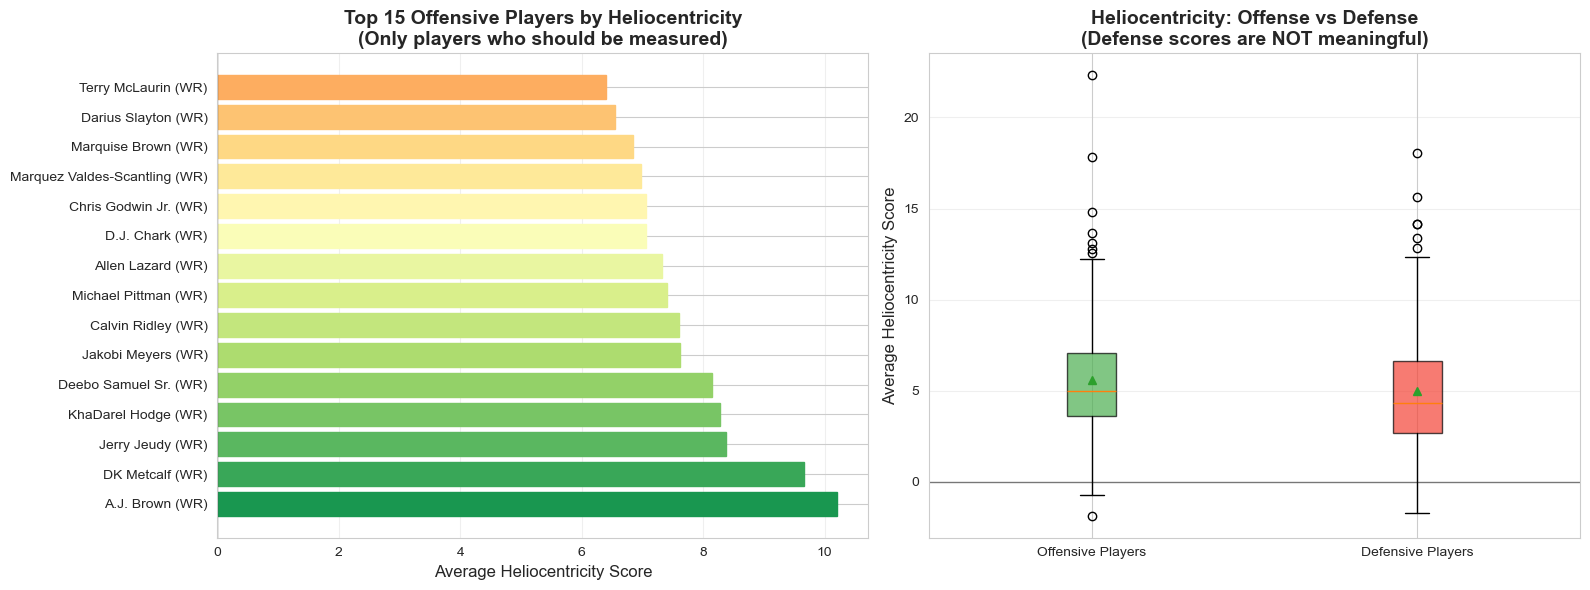


Interpretation:
• GREEN (Offense): These scores are meaningful - measuring defensive attention
• RED (Defense): These scores are NOT meaningful - artifacts of the calculation


In [17]:
# Visualization: Offensive players only
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 offensive players
top_15_off = offensive_qualified.nlargest(15, 'avg_H_score')
bars = axes[0].barh(range(len(top_15_off)), top_15_off['avg_H_score'].values)
axes[0].set_yticks(range(len(top_15_off)))
axes[0].set_yticklabels([f"{name} ({pos})" for name, pos in zip(top_15_off['player_name'], top_15_off['player_position'])])
axes[0].set_xlabel('Average Heliocentricity Score', fontsize=12)
axes[0].set_title('Top 15 Offensive Players by Heliocentricity\n(Only players who should be measured)', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Color bars
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

# Comparison: Offense vs Defense (to show the problem)
off_data = offensive_stats['avg_H_score'].values
def_data = defense_players['avg_H_score'].values

bp = axes[1].boxplot([off_data, def_data], labels=['Offensive Players', 'Defensive Players'],
                      patch_artist=True, showmeans=True)

bp['boxes'][0].set_facecolor('#4CAF50')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('#F44336')
bp['boxes'][1].set_alpha(0.7)

axes[1].set_ylabel('Average Heliocentricity Score', fontsize=12)
axes[1].set_title('Heliocentricity: Offense vs Defense\n(Defense scores are NOT meaningful)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• GREEN (Offense): These scores are meaningful - measuring defensive attention")
print("• RED (Defense): These scores are NOT meaningful - artifacts of the calculation")

In [18]:
# Save corrected offensive-only rankings
offensive_output = offensive_stats[['star_player_id', 'player_name', 'player_position', 
                                     'avg_H_score', 'median_H_score', 'std_H_score', 
                                     'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

offensive_output.to_csv('dataset/helio/offensive_players_heliocentricity.csv', index=False)
print(f"✓ Saved offensive players ranking to dataset/helio/offensive_players_heliocentricity.csv ({len(offensive_output)} players)")

# Also create a pass catchers only version (WR, TE, RB)
pass_catchers = offensive_stats[offensive_stats['player_position'].isin(['WR', 'TE', 'RB'])].copy()
pass_catchers_output = pass_catchers[['star_player_id', 'player_name', 'player_position', 
                                       'avg_H_score', 'median_H_score', 'std_H_score', 
                                       'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

pass_catchers_output.to_csv('dataset/helio/pass_catchers_heliocentricity.csv', index=False)
print(f"✓ Saved pass catchers ranking to dataset/helio/pass_catchers_heliocentricity.csv ({len(pass_catchers_output)} players)")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total players in original dataset: {len(player_stats_with_pos)}")
print(f"  → Offensive players: {len(offensive_stats)} ({len(offensive_stats)/len(player_stats_with_pos)*100:.1f}%)")
print(f"  → Defensive players: {len(defense_players)} ({len(defense_players)/len(player_stats_with_pos)*100:.1f}%) [NOT MEANINGFUL]")
print(f"\nPass catchers (WR/TE/RB): {len(pass_catchers)}")
print(f"  → These are the most relevant for heliocentricity analysis")
print("\n✓ Use offensive_players_heliocentricity.csv or pass_catchers_heliocentricity.csv for valid analysis")

✓ Saved offensive players ranking to dataset/helio/offensive_players_heliocentricity.csv (204 players)
✓ Saved pass catchers ranking to dataset/helio/pass_catchers_heliocentricity.csv (168 players)

SUMMARY
Total players in original dataset: 428
  → Offensive players: 204 (47.7%)
  → Defensive players: 224 (52.3%) [NOT MEANINGFUL]

Pass catchers (WR/TE/RB): 168
  → These are the most relevant for heliocentricity analysis

✓ Use offensive_players_heliocentricity.csv or pass_catchers_heliocentricity.csv for valid analysis


In [19]:
# Top Wide Receivers by Heliocentricity
print("=" * 80)
print("TOP 20 WIDE RECEIVERS BY AVERAGE HELIOCENTRICITY SCORE")
print("=" * 80)

top_wr = wr_stats.nlargest(20, 'avg_H_score')[['player_name', 'avg_H_score', 'median_H_score', 'total_plays', 'cv']]
print(top_wr.to_string(index=False))

print("\n" + "=" * 80)
print("TOP 20 TIGHT ENDS BY AVERAGE HELIOCENTRICITY SCORE")
print("=" * 80)

top_te = te_stats.nlargest(20, 'avg_H_score')[['player_name', 'avg_H_score', 'median_H_score', 'total_plays', 'cv']]
print(top_te.to_string(index=False))

print("\n" + "=" * 80)
print("MOST CONSISTENT WIDE RECEIVERS (Lowest Coefficient of Variation)")
print("=" * 80)

consistent_wr = wr_stats[wr_stats['total_plays'] >= 10].nsmallest(15, 'cv')[['player_name', 'avg_H_score', 'cv', 'total_plays']]
print(consistent_wr.to_string(index=False))

TOP 20 WIDE RECEIVERS BY AVERAGE HELIOCENTRICITY SCORE
          player_name  avg_H_score  median_H_score  total_plays       cv
        DeVonta Smith       22.323          22.323            1      NaN
       Michael Gallup       17.822          16.061            5 0.449669
          Jamal Agnew       13.682          13.689            4 0.127540
          Tutu Atwell       13.131          13.131            1      NaN
          Alec Pierce       12.763          12.763            1      NaN
Equanimeous St. Brown       12.570          12.570            2 0.369212
     Sterling Shepard       12.205          12.205            2 0.992298
         Mack Hollins       11.251          11.251            2 0.302284
           A.J. Brown       10.208          11.597           22 0.579350
       Rashod Bateman       10.025          10.025            1      NaN
          CeeDee Lamb        9.934           8.395            8 0.993557
           DK Metcalf        9.657          10.229           14 0.738

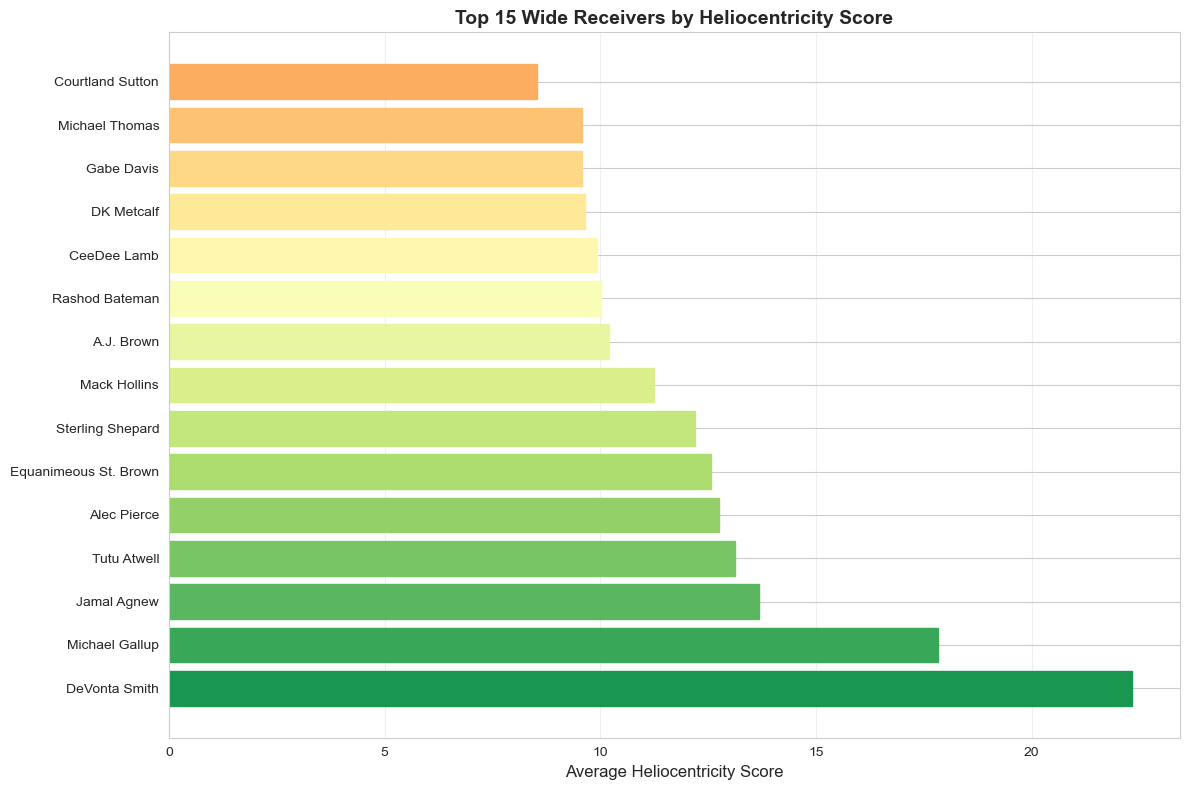

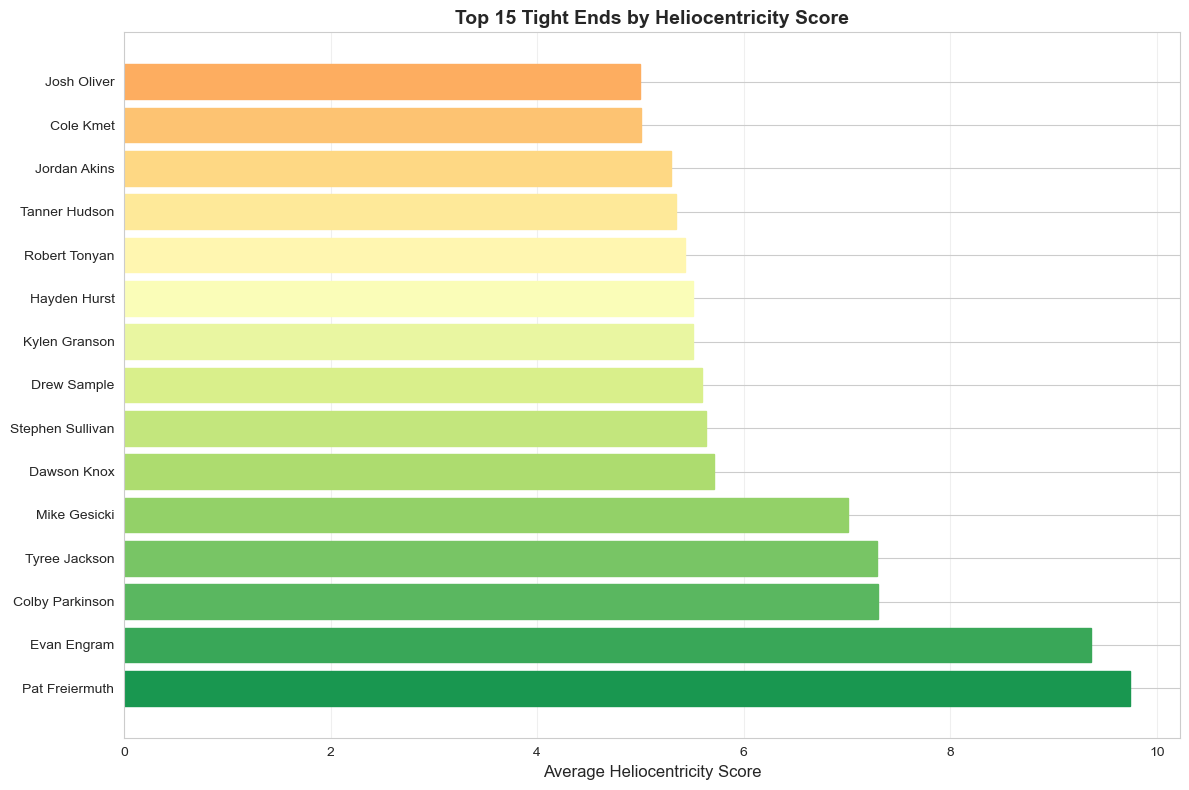

In [20]:
# Visualization: Top 15 WRs by Heliocentricity
fig, ax = plt.subplots(figsize=(12, 8))

top_15_wr = wr_stats.nlargest(15, 'avg_H_score')
bars = ax.barh(range(len(top_15_wr)), top_15_wr['avg_H_score'].values)
ax.set_yticks(range(len(top_15_wr)))
ax.set_yticklabels(top_15_wr['player_name'].values)
ax.set_xlabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Top 15 Wide Receivers by Heliocentricity Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

plt.tight_layout()
plt.show()

# Visualization: Top 15 TEs by Heliocentricity
fig, ax = plt.subplots(figsize=(12, 8))

top_15_te = te_stats.nlargest(15, 'avg_H_score')
bars = ax.barh(range(len(top_15_te)), top_15_te['avg_H_score'].values)
ax.set_yticks(range(len(top_15_te)))
ax.set_yticklabels(top_15_te['player_name'].values)
ax.set_xlabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Top 15 Tight Ends by Heliocentricity Score', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

plt.tight_layout()
plt.show()

/var/folders/py/cfchh_0s3zv0_x826rm19h1r0000gn/T/ipykernel_34524/1375377300.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(position_data, labels=['Wide Receivers', 'Tight Ends', 'Other Positions'],


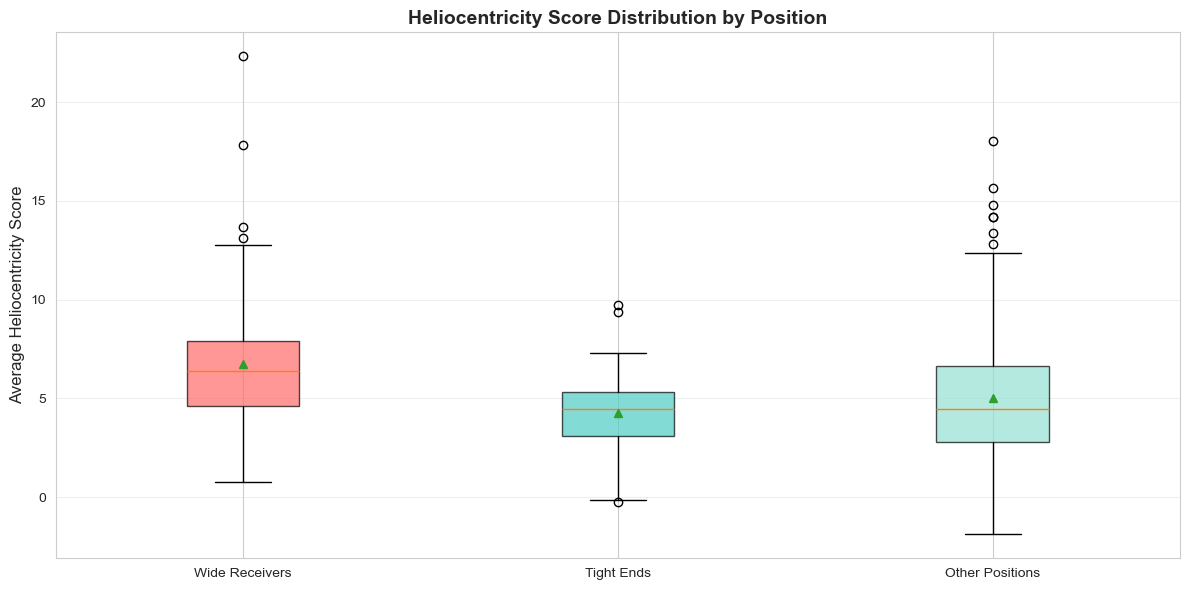


Summary Statistics by Position:

WR:
  Count: 82
  Mean: 6.7583
  Median: 6.4065
  Std: 3.4125

TE:
  Count: 46
  Mean: 4.2456
  Median: 4.4690
  Std: 2.0379

Other:
  Count: 300
  Mean: 5.0108
  Median: 4.4440
  Std: 3.1723


In [21]:
# Comparison: WR vs TE vs Other Positions
fig, ax = plt.subplots(figsize=(12, 6))

# Create position groups
player_stats_with_pos['position_group'] = player_stats_with_pos['player_position'].apply(
    lambda x: 'WR' if x == 'WR' else ('TE' if x == 'TE' else 'Other')
)

position_data = [
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'WR']['avg_H_score'].values,
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'TE']['avg_H_score'].values,
    player_stats_with_pos[player_stats_with_pos['position_group'] == 'Other']['avg_H_score'].values
]

bp = ax.boxplot(position_data, labels=['Wide Receivers', 'Tight Ends', 'Other Positions'],
                patch_artist=True, showmeans=True)

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Average Heliocentricity Score', fontsize=12)
ax.set_title('Heliocentricity Score Distribution by Position', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Position:")
print("=" * 60)
for pos in ['WR', 'TE', 'Other']:
    pos_data = player_stats_with_pos[player_stats_with_pos['position_group'] == pos]['avg_H_score']
    print(f"\n{pos}:")
    print(f"  Count: {len(pos_data)}")
    print(f"  Mean: {pos_data.mean():.4f}")
    print(f"  Median: {pos_data.median():.4f}")
    print(f"  Std: {pos_data.std():.4f}")

In [22]:
# Save WR-specific results
wr_output = wr_stats[['star_player_id', 'player_name', 'avg_H_score', 'median_H_score', 
                       'std_H_score', 'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

te_output = te_stats[['star_player_id', 'player_name', 'avg_H_score', 'median_H_score', 
                       'std_H_score', 'cv', 'total_plays']].sort_values('avg_H_score', ascending=False)

wr_output.to_csv('/Users/gordantao/Documents/Dev/sail/big_data_bowl/dataset/helio/wr_heliocentricity_rankings.csv', index=False)
te_output.to_csv('/Users/gordantao/Documents/Dev/sail/big_data_bowl/dataset/helio/te_heliocentricity_rankings.csv', index=False)

print(f"Saved WR rankings to dataset/helio/wr_heliocentricity_rankings.csv ({len(wr_output)} players)")
print(f"Saved TE rankings to dataset/helio/te_heliocentricity_rankings.csv ({len(te_output)} players)")

Saved WR rankings to dataset/helio/wr_heliocentricity_rankings.csv (82 players)
Saved TE rankings to dataset/helio/te_heliocentricity_rankings.csv (46 players)


## 8. Team Offense Analysis

Identify which offensive teams are best at creating separation and open looks for their receivers.

In [23]:
# Load team information from supplementary data
print("Loading team and play information...")

# Read game_id, play_id, possession_team from supplementary data
supp_data = pd.read_csv('dataset/supplementary_data.csv', 
                         usecols=['game_id', 'play_id', 'possession_team'])

# Get unique play-team mappings (one row per play)
play_teams = supp_data[['game_id', 'play_id', 'possession_team']].drop_duplicates()

print(f"Loaded team data for {len(play_teams)} unique plays")
print(f"Teams in dataset: {sorted(play_teams['possession_team'].unique())}")

# Merge with heliocentricity scores
helio_with_teams = helio_df.merge(play_teams, on=['game_id', 'play_id'], how='left')

print(f"\nPlays with team data: {helio_with_teams['possession_team'].notna().sum()} ({helio_with_teams['possession_team'].notna().sum() / len(helio_with_teams) * 100:.1f}%)")
print(f"\nSample data:")
helio_with_teams[['game_id', 'play_id', 'player_name', 'possession_team', 'H_score']].head(10)

Loading team and play information...
Loaded team data for 18009 unique plays
Teams in dataset: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

Plays with team data: 2822 (100.0%)

Sample data:


,game_id,play_id,player_name,possession_team,H_score
0,2023091011,2834,Justin Evans,NE,-2.107699
1,2023101507,3581,Parry Nickerson,CAR,2.618695
2,2023121708,649,Roquan Smith,JAX,2.114915
3,2023110507,3045,Jaylon Johnson,NO,5.813387
4,2023100106,3723,Christian Rozeboom,IND,3.719914
5,2023100500,1631,Cody Barton,CHI,3.722668
6,2023091710,3659,Leighton Vander Esch,NYJ,3.257077
7,2023121006,2931,Quincy Williams,HOU,-1.133264
8,2023092501,4318,Germaine Pratt,LA,5.275827
9,2023121705,3520,Royce Freeman,LA,4.692144


In [24]:
# Aggregate heliocentricity by offensive team
team_stats = helio_with_teams.groupby('possession_team').agg({
    'H_score': ['mean', 'median', 'std', 'count'],
    'game_id': 'nunique',
    'play_id': 'nunique'
}).round(3)

# Flatten column names
team_stats.columns = ['_'.join(col).strip() for col in team_stats.columns.values]
team_stats.rename(columns={
    'H_score_mean': 'avg_H_score',
    'H_score_median': 'median_H_score',
    'H_score_std': 'std_H_score',
    'H_score_count': 'total_plays',
    'game_id_nunique': 'games',
    'play_id_nunique': 'unique_plays'
}, inplace=True)

# Calculate coefficient of variation
team_stats['cv'] = (team_stats['std_H_score'] / team_stats['avg_H_score'].abs()).replace([np.inf, -np.inf], np.nan)

team_stats = team_stats.reset_index()

print(f"Team-level statistics calculated for {len(team_stats)} teams\n")

# Top teams by average heliocentricity (best at creating separation)
print("=" * 80)
print("TOP 10 OFFENSES - BEST AT CREATING SEPARATION FOR RECEIVERS")
print("=" * 80)
top_offenses = team_stats.nlargest(10, 'avg_H_score')[['possession_team', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games']]
print(top_offenses.to_string(index=False))

print("\n" + "=" * 80)
print("BOTTOM 10 OFFENSES - STRUGGLED TO CREATE SEPARATION")
print("=" * 80)
bottom_offenses = team_stats.nsmallest(10, 'avg_H_score')[['possession_team', 'avg_H_score', 'median_H_score', 'std_H_score', 'total_plays', 'games']]
print(bottom_offenses.to_string(index=False))

print("\n" + "=" * 80)
print("MOST CONSISTENT OFFENSES (Low Variability)")
print("=" * 80)
consistent_offenses = team_stats.nsmallest(10, 'cv')[['possession_team', 'avg_H_score', 'cv', 'total_plays']]
print(consistent_offenses.to_string(index=False))

Team-level statistics calculated for 32 teams

TOP 10 OFFENSES - BEST AT CREATING SEPARATION FOR RECEIVERS
possession_team  avg_H_score  median_H_score  std_H_score  total_plays  games
            ATL        6.580           5.283        4.699           66     16
            PHI        6.310           5.122        5.498           91     17
            BUF        6.306           4.831        5.071           76     17
            NYG        6.230           5.261        4.854           91     17
            IND        5.851           5.222        4.718           85     17
            DEN        5.741           4.535        5.207           69     17
             NO        5.578           4.634        4.172           95     17
            JAX        5.539           4.330        5.008           97     17
            CAR        5.525           4.891        4.403           81     17
            PIT        5.492           4.431        5.346           78     17

BOTTOM 10 OFFENSES - STRUGGLED TO 

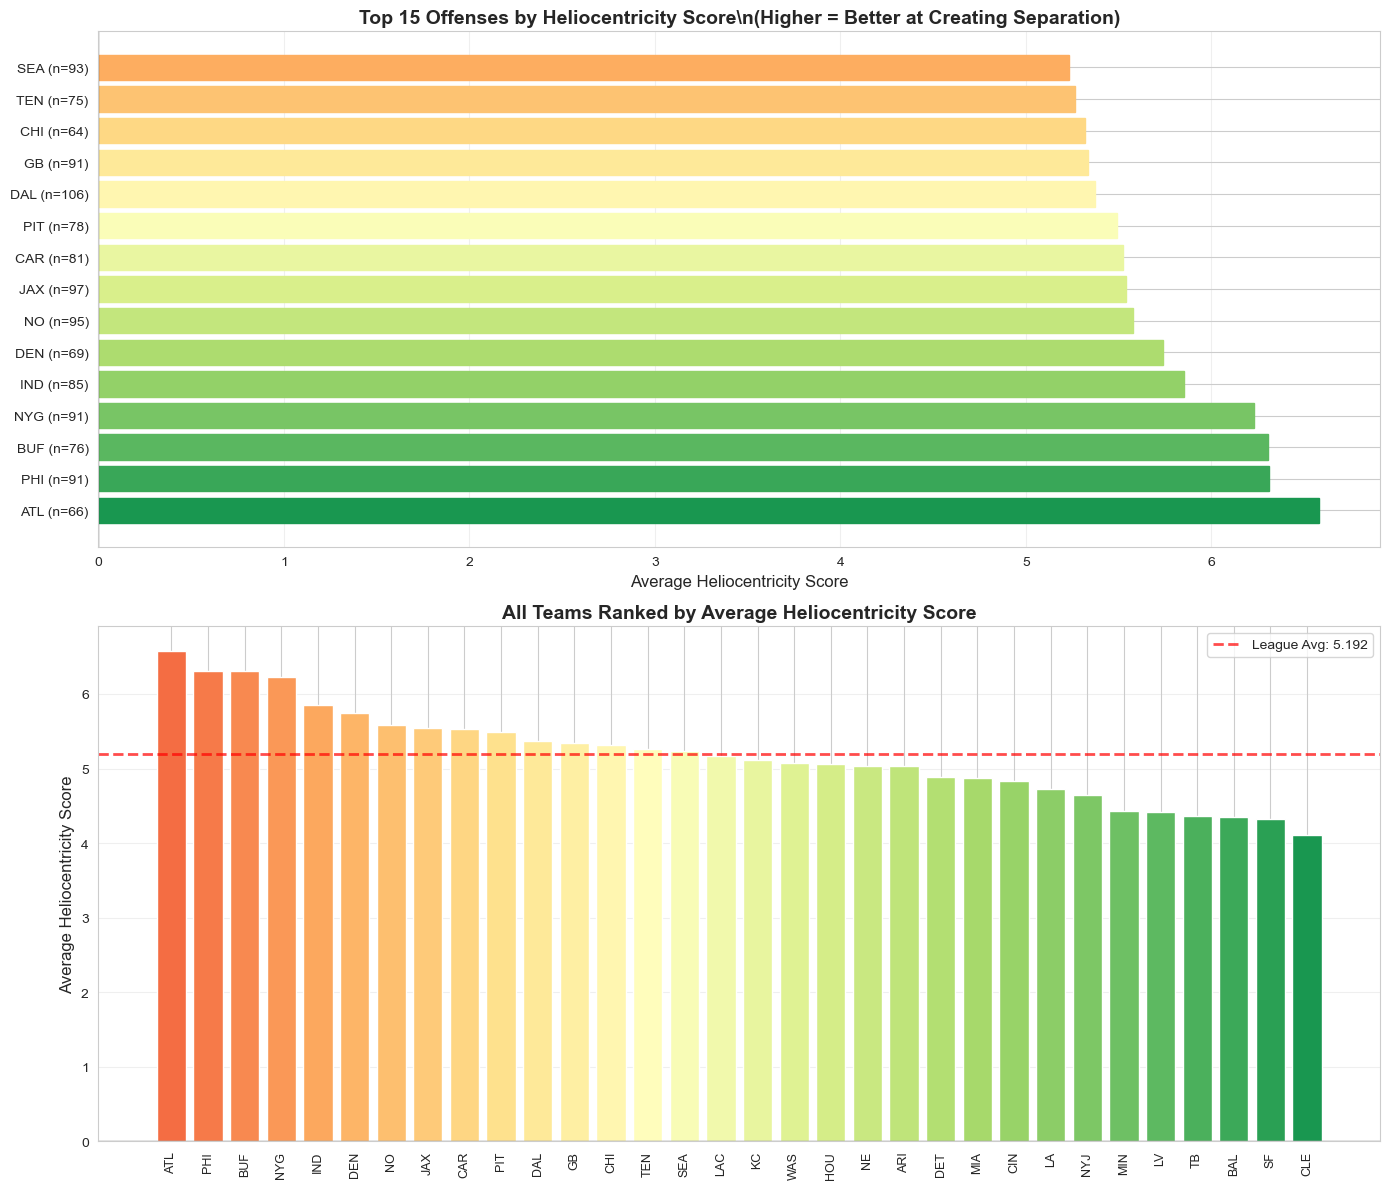

In [25]:
# Visualization: Team offensive performance
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Bar chart: Top 15 teams
top_15_teams = team_stats.nlargest(15, 'avg_H_score')
bars = axes[0].barh(range(len(top_15_teams)), top_15_teams['avg_H_score'].values)
axes[0].set_yticks(range(len(top_15_teams)))
axes[0].set_yticklabels([f"{team} (n={n})" for team, n in zip(top_15_teams['possession_team'], top_15_teams['total_plays'])])
axes[0].set_xlabel('Average Heliocentricity Score', fontsize=12)
axes[0].set_title('Top 15 Offenses by Heliocentricity Score\\n(Higher = Better at Creating Separation)', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[0].grid(axis='x', alpha=0.3)

# Color bars by value
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors[::-1]):
    bar.set_color(color)

# All teams comparison
team_stats_sorted = team_stats.sort_values('avg_H_score', ascending=False)
bars2 = axes[1].bar(range(len(team_stats_sorted)), team_stats_sorted['avg_H_score'].values, 
                     color=plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(team_stats_sorted))))
axes[1].set_xticks(range(len(team_stats_sorted)))
axes[1].set_xticklabels(team_stats_sorted['possession_team'].values, rotation=90, fontsize=9)
axes[1].set_ylabel('Average Heliocentricity Score', fontsize=12)
axes[1].set_title('All Teams Ranked by Average Heliocentricity Score', fontsize=14, fontweight='bold')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].axhline(team_stats_sorted['avg_H_score'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f"League Avg: {team_stats_sorted['avg_H_score'].mean():.3f}")
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [26]:
# Team-Player combinations: Which teams get the most from their receivers?
team_player_stats = helio_with_teams.groupby(['possession_team', 'star_player_id', 'player_name']).agg({
    'H_score': ['mean', 'count']
}).round(3)

team_player_stats.columns = ['avg_H_score', 'play_count']
team_player_stats = team_player_stats.reset_index()

# Filter for meaningful sample size
team_player_qualified = team_player_stats[team_player_stats['play_count'] >= 5]

print("=" * 80)
print("TOP 20 TEAM-PLAYER COMBINATIONS (Min 5 plays)")
print("=" * 80)
top_combos = team_player_qualified.nlargest(20, 'avg_H_score')[['possession_team', 'player_name', 'avg_H_score', 'play_count']]
print(top_combos.to_string(index=False))

# For each top team, show their best receivers
print("\n" + "=" * 80)
print("BEST RECEIVERS FOR TOP 5 OFFENSES")
print("=" * 80)

for team in top_offenses.head(5)['possession_team'].values:
    team_receivers = team_player_qualified[team_player_qualified['possession_team'] == team].nlargest(5, 'avg_H_score')
    print(f"\n{team}:")
    print(team_receivers[['player_name', 'avg_H_score', 'play_count']].to_string(index=False))

TOP 20 TEAM-PLAYER COMBINATIONS (Min 5 plays)
possession_team         player_name  avg_H_score  play_count
            DAL      Michael Gallup       17.822           5
            TEN   Marshon Lattimore       13.161           5
            BUF    Darious Williams       11.915           5
            CIN    Darious Williams       11.860           6
            DAL           D.J. Reed       11.672           6
            PHI          A.J. Brown       10.208          22
            DAL         CeeDee Lamb        9.934           8
            SEA          DK Metcalf        9.657          14
            JAX    Shaquill Griffin        9.631           6
             NO         Jeff Okudah        9.236           5
            MIN  Alexander Mattison        9.003           8
            NYG         Matt Breida        8.899           5
            DEN    Courtland Sutton        8.545           7
            DEN         Jerry Jeudy        8.381          16
            ATL      KhaDarel Hodge    

In [27]:
# Save team-level results
team_output_path = 'dataset/helio/team_offense_heliocentricity.csv'
team_stats.sort_values('avg_H_score', ascending=False).to_csv(team_output_path, index=False)
print(f"✓ Saved team offense statistics to {team_output_path}")

team_player_output = 'dataset/helio/team_player_heliocentricity.csv'
team_player_qualified.sort_values('avg_H_score', ascending=False).to_csv(team_player_output, index=False)
print(f"✓ Saved team-player combinations to {team_player_output}")

print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("Teams with HIGH heliocentricity scores:")
print("  → Effective at creating separation through scheme, play design, or talent")
print("  → Defenses gave their receivers MORE space than expected")
print("  → Could indicate good route concepts, misdirection, or elite receiver talent")
print("\nTeams with LOW heliocentricity scores:")
print("  → Struggled to create separation for receivers")
print("  → Defenses played TIGHTER coverage than expected")
print("  → Could indicate predictable schemes or receivers who draw less attention")

✓ Saved team offense statistics to dataset/helio/team_offense_heliocentricity.csv
✓ Saved team-player combinations to dataset/helio/team_player_heliocentricity.csv

INTERPRETATION
Teams with HIGH heliocentricity scores:
  → Effective at creating separation through scheme, play design, or talent
  → Defenses gave their receivers MORE space than expected
  → Could indicate good route concepts, misdirection, or elite receiver talent

Teams with LOW heliocentricity scores:
  → Struggled to create separation for receivers
  → Defenses played TIGHTER coverage than expected
  → Could indicate predictable schemes or receivers who draw less attention
